# Simulating the action potential with random walk of ions
#### By Viroshaan Uthayamoorthy, Olav Bakke and Arne Rustad

## Functions

In [1]:
import numpy as np
from scipy.stats import norm
from random import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
import matplotlib.path as path
import time
import matplotlib as mpl
%matplotlib inline
#%matplotlib nbagg
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80


global kB, T0, e, number

kB = 1.38e-23
T0 = 273+37
e = 1.602 * 1e-19

def randomStep(pLeft, pRight):
    fl = random()
    if (fl <= pLeft):
        return -1
    elif (fl >= 1 - pRight):
        return 1
    else:
        return 0

def randWalk1D():
    lst = [0 for i in range(1000)]
    
    for i in range(100):
        lst = [item + randomStep(0.5, 0.5) for item in lst]

    return np.array(lst)

def V1(x, k, h):
    return k * x

def V2(x, k, h):
    if x >= -6 * h and x <= 6 * h:
        return k
    else:
        return 0

def V3(x, k, h):
    if x > 3 * h:
        return k
    elif x < -3 * h:
        return -k
    else:
        return k * (-1 + 2 * (x + 3 * h) / (6 * h))    
    
def calcBins(lst):
    temp = set([])
    for item in lst:
        temp.add(item)
    return len(temp)

def plotNorm(data, size = (16, 8), numbBins = 70):
    fig = plt.figure(figsize=size)

    mu, std = norm.fit(data)

    plt.hist(data, bins=calcBins(data), density=True, alpha=0.6, color='g', label = "Posisjonshistogram")

    xmin, xmax = plt.xlim()
    x = np.linspace(-100, 100, 200)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=1, label= "Normalfordeling")
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title("Random walk in one dimension", fontsize = 25)
    plt.legend(loc = "best")
    axes = plt.gca()
    axes.set_xlim([-110, 110])    
    
    plt.show()

def plotNormFour(data, titleMain, titleSub, size = (16, 16), numBins = [25,25,25,25],
                 histogram = [1, 1, 1, 1], titleNewLines = 0, V=V1, betaKLst = [0.1, 0.5, 1, 10]):
    fig = plt.figure(figsize=size)
    plt.suptitle(titleMain, fontsize = 25, y = 0.91 + titleNewLines * 0.033)
    plt.title("Random walk in one dimension")
    beta = 1 / (kB * T0)
    x = np.linspace(-100, 100, 200)
    plt.subplot(2, 1, 1)
    plt.plot(x, [V(x[j], 1, 1) for j in range(len(x))], label = "$\\beta V(x)$")
    plt.xlabel("Steps from origin")
    plt.ylabel("$\\beta$ V []")
    plt.legend(loc = "best")
    for i in range(4):
        plt.subplot(4, 2, i + 5)
        if histogram[i]:
            mu, std = norm.fit(data[i])
        plt.hist(data[i], bins=calcBins(data[i]), density=True, alpha=0.6, color='g', label = "Positional histogram")
        xmin, xmax = plt.xlim()
        if histogram[i]:
            p = norm.pdf(x, mu, std)
            plt.plot(x, p, 'k', linewidth=1, label= "Normal distribution")
        plt.legend(loc = "best")
        plt.title(titleSub[i])
        axes = plt.gca()
        axes.set_xlim([-110, 110])        
    
    
    plt.show()
    
def plot_sbs(x1, x2, ylist1, ylist2, xl1="", xl2="", yl1="", yl2="", t1="", t2=""):
    fig = plt.figure(figsize=(16, 5))
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel(xl1, fontsize=20)
    ax1.set_ylabel(yl1, fontsize=20)
    ax1.set_title(t1, fontsize=20)
    for i in range(len(ylist1)):
        if isinstance(ylist1[i][1], str):  # Tries for color
            try:  # Tries for legend
                ax1.plot(x1, ylist1[i][0], color=ylist1[i][1], label=ylist1[i][2])
                ax1.legend()
            except:
                ax1.plot(x1, ylist1[i][0], color=ylist1[i][1])
        else:
            ax1.plot(x1, ylist1[i])
    
    if (ylist2):
        ax2 = fig.add_subplot(122)
        ax2.set_xlabel(xl2, fontsize=20)
        ax2.set_ylabel(yl2, fontsize=20)
        ax2.set_title(t2, fontsize=20)
        for i in range(len(ylist2)):
            if isinstance(ylist2[i][1], str):  # Tries for color
                try:  # Tries for legend
                    ax2.plot(x2, ylist2[i][0], color=ylist2[i][1], label=ylist2[i][2])
                    ax2.legend()
                except:
                    ax2.plot(x2, ylist2[i][0], color=ylist2[i][1])
            else:
                ax2.plot(x2, ylist2[i])
        
    plt.show()
    
def pPlus(beta, V, x, k, h):
    return 1 / (1 + np.exp(-1 * beta * (V(x - h, k, h) - V(x + h, k, h))))

def pMinus(pPlus):
    return 1 - pPlus

def randWalkWithPotential(V, betaK, beta, h = 1, dataSize = 1000, iter = 100):
    k = betaK / beta
    lst = [0 for i in range(dataSize)]
    
    for i in range(iter):
        for index in range(len(lst)):
            pRight = pPlus(beta, V, lst[index], k, h)
            pLeft = pMinus(pRight)
            lst[index] += randomStep(pLeft, pRight)

    return np.array(lst)

def getDataFourPlots(V, betaKValues, beta, h = 1, dataSize = 1000, iter = 100):
    for i in range(len(betaKValues)):
        if i == 0:
            data = np.array([randWalkWithPotential(V, betaKValues[i], beta)])
        else:
            data = np.append(data, np.array([randWalkWithPotential(V, betaKValues[i], beta)]), axis = 0)

    titles = []
    for i in range(len(betaKValues)):
        titles.append("$\\beta k = " + str(betaKValues[i]) + "$")
        
    return data, titles

def calculateQ_int(sodium, potassium, h):
    Q_int = 0
    for s in (sodium):
        if s < -h:
            Q_int += 0.1e-3
    for p in (potassium):
        if p < -h:
            Q_int += 0.1e-3
    return Q_int

def calculateQ_ext(sodium, potassium, h):
    Q_ext = 0
    for s in (sodium):
        if s > h:
            Q_ext += 0.1e-3
    for p in (potassium):
        if p > h:
            Q_ext += 0.1e-3
    return Q_ext

def calculateV(Q, C=5/70):
    return Q / C

def V4(x, h, L, V_ext,V_int, V0):
    if x <= -L/2 or x >= L/2:
        return np.inf
    
    if x <-h:
        return V_int
    elif -h <= x and x <= h:
        return V_int + (V_ext - V_int) * (x + h) / (2*h) + V0
    else:
        return V_ext

def pPlusCell(beta, V, x, h, L, V_ext, V_int, V0):
    return 1 / (1 + np.exp(-1 * beta * (V(x - h, h, L, V_ext, V_int, V0) - V(x + h, h, L, V_ext, V_int, V0))))

def randWalkCell(beta_VSod, beta_VPot, L = 50, h = 1, sodInside = 50, sodOutside = 1450,
                 potInside = 1400, potOutside = 50, iter = 500):
    beta = 1/ (kB*T0) * e
    VSod = beta_VSod / beta
    VPot = beta_VPot / beta    
    
    sodium = []
    potassium = []
    
    V_values = []
    for i in range(sodOutside + sodInside):
        if i < sodInside:
            sodium.append(-L // 4)
        else:
            sodium.append(L // 4)
    
    for i in range(potInside + potOutside):
        if i < potInside:
            potassium.append(-L // 4)
        else:
            potassium.append(L // 4)
    
    Q_int = calculateQ_int(sodium, potassium, h)
    Q_ext = calculateQ_ext(sodium, potassium, h)
    
    V_int = calculateV(Q_int)
    V_values.append(V_int)
    V_ext = calculateV(Q_ext)
    
    for i in range(iter):
        
        for index in range(len(potassium)):
            pRight = pPlusCell(beta, V4, potassium[index], h, L, V_ext, V_int, VPot)
            pLeft = pMinus(pRight)
            potassium[index] += randomStep(pLeft, pRight)
            
        for index in range(len(sodium)):
            pRight = pPlusCell(beta, V4, sodium[index], h, L, V_ext, V_int, VSod)
            pLeft = pMinus(pRight)
            sodium[index] += randomStep(pLeft, pRight)
        
        Q_int = calculateQ_int(sodium, potassium, h)
        V_int = calculateV(Q_int)
        V_values.append(V_int)
    
    return (np.array(V_values) - np.array(V_ext)) / 1e-3, sodium, potassium

def randWalkCellWithGates(SPP=False, L =50, h = 1, sodInside = 50, sodOutside = 1450,
                 potInside = 1400, potOutside = 50, iter = 500, consentrationLst=[]):
    
    beta = 1 / (kB*T0) * e
    VClosed = 50 / beta
    VOpened = 1 / beta
    VSod = VOpened
    VPot = VClosed
    
    potOpen = False
        
    sodium = []
    potassium = []
    
    V_values = []
    for i in range(sodOutside + sodInside):
        if i < sodInside:
            sodium.append(-L // 4)
        else:
            sodium.append(L // 4)
    
    for i in range(potInside + potOutside):
        if i < potInside:
            potassium.append(-L // 4)
        else:
            potassium.append(L // 4)
    
    Q_int = calculateQ_int(sodium, potassium, h)
    Q_ext = calculateQ_ext(sodium, potassium, h)
    
    consentrationLst.append([calculateQ_int([], potassium, h), calculateQ_ext([], potassium, h), 0.145 - calculateQ_int([], potassium, h) - calculateQ_ext([], potassium, h)])
        
    V_int = calculateV(Q_int)
    V_ext = calculateV(Q_ext)
    V_values.append((V_int - V_ext) / 1e-3)
    
    for i in range(iter):
        
        if SPP and i % 10 == 0:
            sodLst = []
            potLst = []
            sodCount = 0
            potCount = 0
            for index in range(len(potassium)):
                if potassium[index] > h:
                    potLst.append(index)
                    
                if len(potLst) >= 2:
                    break
            
            for index in range(len(sodium)):
                if sodium[index] < -h:
                    sodLst.append(index)
                
                if len(sodLst) >= 3:
                    if len(potLst) >= 2:
                        sodium[sodLst[0]] = h + 1
                        sodium[sodLst[1]] = h + 1
                        sodium[sodLst[2]] = h + 1
                        
                        potassium[potLst[0]] = -h - 1
                        potassium[potLst[1]] = -h - 1
                        
                    break
        
        for index in range(len(potassium)):
            pRight = pPlusCell(beta, V4, potassium[index], h, L, V_ext, V_int, VPot)
            pLeft = pMinus(pRight)
            potassium[index] += randomStep(pLeft, pRight)
            
        for index in range(len(sodium)):
            pRight = pPlusCell(beta, V4, sodium[index], h, L, V_ext, V_int, VSod)
            pLeft = pMinus(pRight)
            sodium[index] += randomStep(pLeft, pRight)
        
        Q_int = calculateQ_int(sodium, potassium, h)
        V_int = calculateV(Q_int)
        V_values.append((V_int - V_ext) / 1e-3)
        
        if V_values[-1] >= 30 and not potOpen:
            VSod = VClosed
            VPot = VOpened
            potOpen = True
        elif V_values[-1] <= -70 and potOpen:
            consentrationLst.append([calculateQ_int([], potassium, h), calculateQ_ext([], potassium, h), 0.145 - calculateQ_int([], potassium, h) - calculateQ_ext([], potassium, h)])
            VPot = VClosed
            VSod = VOpened
            potOpen = False
    
    return np.array(V_values), sodium, potassium

## Task 2.1

By inserting the given function into the diffusion equation, we see that the function is a solution to the diffusion equation. 

\begin{equation}
\frac{\partial \phi}{\partial t} = D\frac{\partial^2\phi}{\partial x^2}
\end{equation}


\begin{equation}
\tilde{\phi} = \frac{1}{\sqrt{4\pi D t}}e^{-\frac{(x-\mu)^2}{4 D t}}
\end{equation}
 
\begin{equation}
\frac{\partial \tilde{\phi}}{\partial t} = \frac{t^{-3/2}}{2\sqrt{4\pi D}}e^{-\frac{(x-\mu)^2}{4 D t}}(\frac{(x-\mu)^2}{2 D t}-1)
\end{equation}

\begin{equation}
\frac{\partial^2 \tilde{\phi}}{\partial x^2} = \frac{t^{-3/2}}{2 D \sqrt{4\pi D}}e^{-\frac{(x-\mu)^2}{4 D t}}(\frac{(x-\mu)^2}{2 D t}-1)
\end{equation}

By inspecting the different partial derivatives of $\tilde{\phi}$ one can see that the only factor seperating the different partial derivatives is D. Therefore $\tilde{\phi}$ indeed is a solution to the diffusion equation.

## Tasks 2.2.1-2.2.2

The initial condition 

\begin{equation}
\phi(x,0) = \delta(x-x_0) = \frac{1}{2\pi} \int_{- \infty}^{\infty} e^{ik(x-x_0)} dk
\end{equation}

Using the taylor expansion of $\phi(x,t)$ we get:

\begin{equation}
\phi(x,t) = \phi(x,0) + \sum_{n=1}^{\infty}\frac{t^n}{n!}\frac{\partial^n}{\partial t'^n}\phi(x,t'), \ \ \ \ t' = 0
\end{equation}

The general solution can be rewritten. By using the diffusion equation, the time derivative of the diffusion function can be written as a second derivative with respect to x. Inserting this into the general solution yields:

\begin{equation}
\phi(x,t) = \sum_{n=0}^{\infty}\frac{t^n}{n!}D^n\frac{\partial^{2n} \phi(x,0)}{\partial x^{2n}}
\end{equation}


By the insertion of the fourier representation of the inital condition $\phi(x,0)$ this expression can be expressed as:

\begin{equation}
\phi(x,t) =\frac{1}{2\pi}\int_{-\infty}^{\infty}\sum_{n=0}^{\infty}\frac{(tD)^n}{n!}\frac{\partial^{2n}}{\partial x^{2n}}e^{-ik(x-y)}dk
\end{equation}

\begin{equation}
\phi(x,t) =\frac{1}{2\pi}\int_{-\infty}^{\infty}\sum_{n=0}^{\infty}\frac{(-k^2tD)^n}{n!}e^{-ik(x-y)}dk
\end{equation}

By using the taylor expansion of the exponential function in reverse this expression can be rewritten as: 

\begin{equation}
\phi(x,t) = \frac{1}{2\pi} \int_{- \infty}^{\infty} e^{- D k^2 t}e^{ik(x-x_0)} dk
\end{equation}

By completing the square of the expression of the exponention function, the integral can be expressed as:

\begin{equation}
\phi(x,t) = \frac{1}{2\pi}e^{-\frac{Dt(x-x_0)}{Dt^2}} \int_{- \infty}^{\infty} e^{- D t (k+\frac{i(x-x_0)}{Dt})^2} dk
\end{equation}

Using substitution and solving the resulting gaussian integral yields the answer:

\begin{equation}
\phi(x,t) = \frac{1}{\sqrt{4 D \pi t}}e^{-\frac{(x-x_0)^2}{4 D t}}
\end{equation}

 This expression is a normal distribution in x. By comparing this expression to the expression of a normal distribution, we notice that $x_0$ is the mean value while the variance $\sigma^2 = 2Dt $ is proportional to both t and D. This implies that the longer the diffusion process is run, the more spread the distribution of particles becomes. Also the higher the diffusion coefficient, the more spread the distribution becomes. Physically this means that an increase in the diffusion coefficient will result in faster diffusion, implying that the particles will move farther from the release point. This can be made sense of by inspection of the diffusion equation. The equation states that the rate of diffusion is proportional to the diffusion coefficient D and the second derivative with respect to x.
 
 ## Task 2.2.3
 
 If the initial condition is an arbitrary function g(x) the solution differs slightly from the previous answer. The general $\phi$ from (5) can in this case be written as:
 
 \begin{equation}
\phi(x,t) = \sum_{n=0}^{\infty}\frac{t^n}{n!}D^n\frac{\partial^{2n} g(x)}{\partial x^{2n}}
\end{equation}

Now by inserting the fourier representation of g(y) this expression can be expressed as: 

 \begin{equation}
\phi(x,t) = \sum_{n=0}^{\infty}\frac{(tD)^n}{n!}\frac{\partial^{2n} }{\partial x^{2n}}\int_{-\infty}^{\infty} g(y) \frac{1}{2\pi}\int_{-\infty}^{\infty} e^{-ik(x-y)}dkdy
\end{equation}

The only part of this expression that is x-dependent is the exponential expression. The second-derivative of this expression is known from the previous exercise, and inserted into this expression turns into:

\begin{equation}
\phi(x,t) = \sum_{n=0}^{\infty}\frac{(tD)^n}{n!}\int_{-\infty}^{\infty}g(y)\frac{1}{2\pi}\int_{-\infty}^{\infty}(-k^2)^{n}e^{-k(x-y)} dkdy
\end{equation}

\begin{equation}
\phi(x,t) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}g(y)\frac{1}{2\pi}\sum_{n=0}^{\infty}\frac{(-k^2tD)^n}{n!}e^{-ik(x-y)}dkdy
\end{equation}

By using the taylor expansion of $e^{x}$ the sum can be rewritten in exponential form. This yields the expression below in which the inner integral is a known gauss integral from the previous exercise. 

\begin{equation}
\phi(x,t) = \int_{-\infty}^{\infty}g(y)\int_{-\infty}^{\infty}\frac{1}{2\pi}e^{-k^2tD}e^{-ik(x-y)}dkdy
\end{equation}

\begin{equation}
\phi(x,t) = \frac{1}{\sqrt{4Dt}}\int_{-\infty}^{\infty}g(y)e^{-\frac{(x-y)^2}{4Dt}} dy
\end{equation}

This is the general solution to the diffusion equation with an arbitrary initial condition g(x).

## Oppgave 3

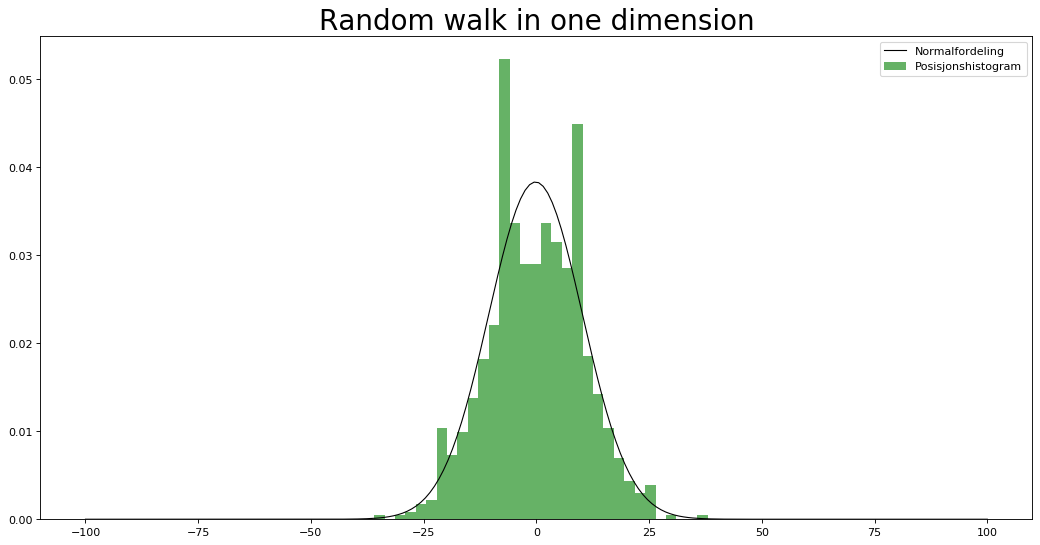

In [2]:
data = randWalk1D()
plotNorm(data)

The histogram and the normal distribution are both plotted. As expected from the theory above, the position of the particles can be represented as a normal distribution around the mean value zero. It is zero because the particles are dropped off at this point before they start random-walking. Another aspect to note is that every other position has no particles in it. This is because the particles in the simulation have a 50/50 chance of walking to left and right, and it is therefore impossible for it to remain in a spot. The simulation is only run an even amount of times with stepsize equal 1, resulting in a positional distribution that only has even position arguments. However due to the binsize of the plot, this could not be represented. 

## Oppgave 5)

### 5.1)
$\beta k$ is the ratio between the potential energy and thermal energy (kinetic energy). An increase in $\beta k$ increases the effect of the difference in potential. This explains why the particle can seemingly move randomly around a potential when $\beta k$ is small, while the particles' movement are dependent on the potential when the ratio between potential and kinetic energy is large. As the potential barrier increases, the probability of a particle moving against the direction of the potential decreases. Physically one would expect to see the particle moving towards a lower potential, which as we will see is a claim supported by the simulations.

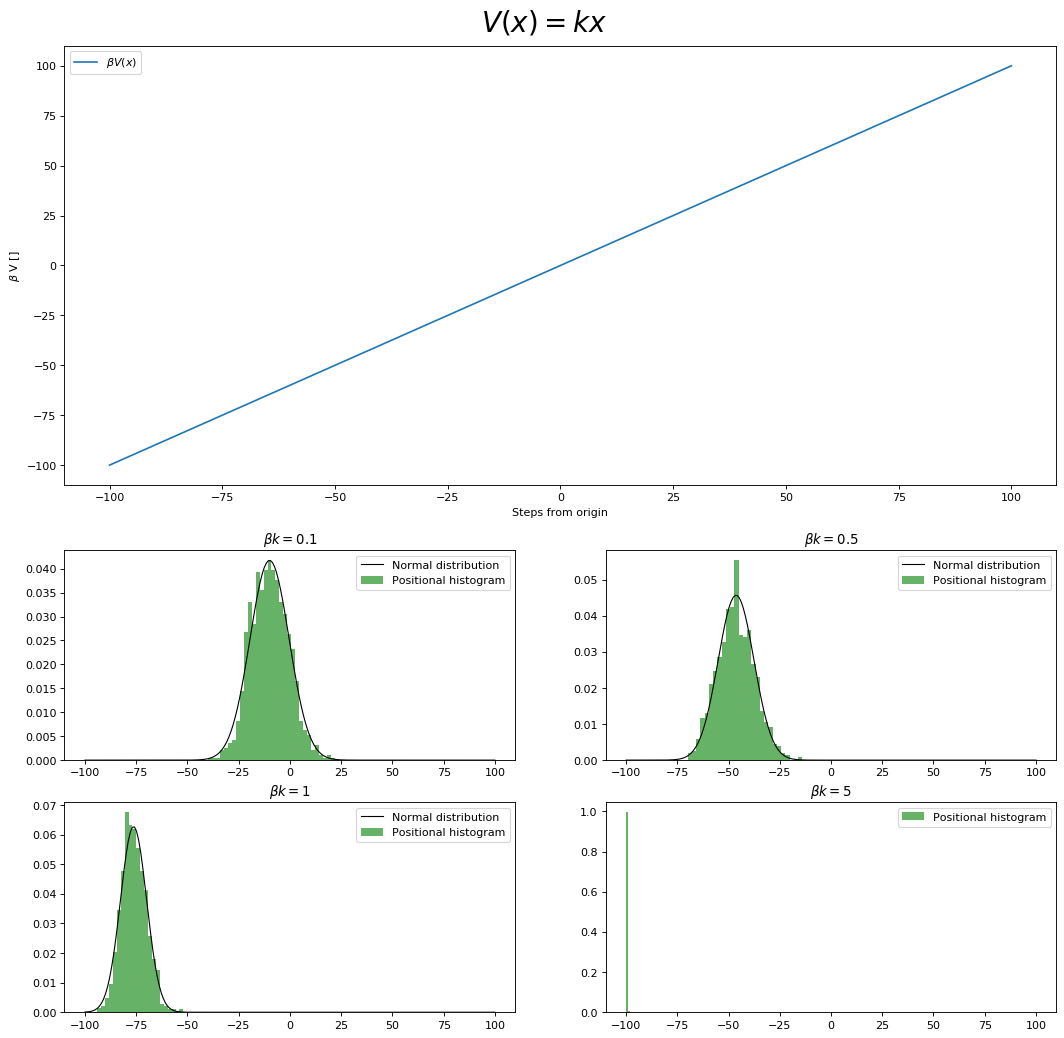

In [3]:
betaKValues1 = (0.1,0.5,1,5)
titleMain = "$V(x)=kx$"
lstParticles1, titleSub = getDataFourPlots(V1, betaKValues1, 1)
plotNormFour(lstParticles1, titleMain, titleSub, histogram = [1, 1, 1, 0], V=V1)

The potential as shown by the plot of the potential is linearly increasing with respect to x. This implies that the lower the x, the lower the potential. With an increase in $\beta k$ the difference between potential and kinetic energy increases drastically, which means that the probability of the particle moving left increases. This is shown in the normal plot as the mean value is shifted towards increasing negative values of x as $\beta k$ increases.
### 5.2)

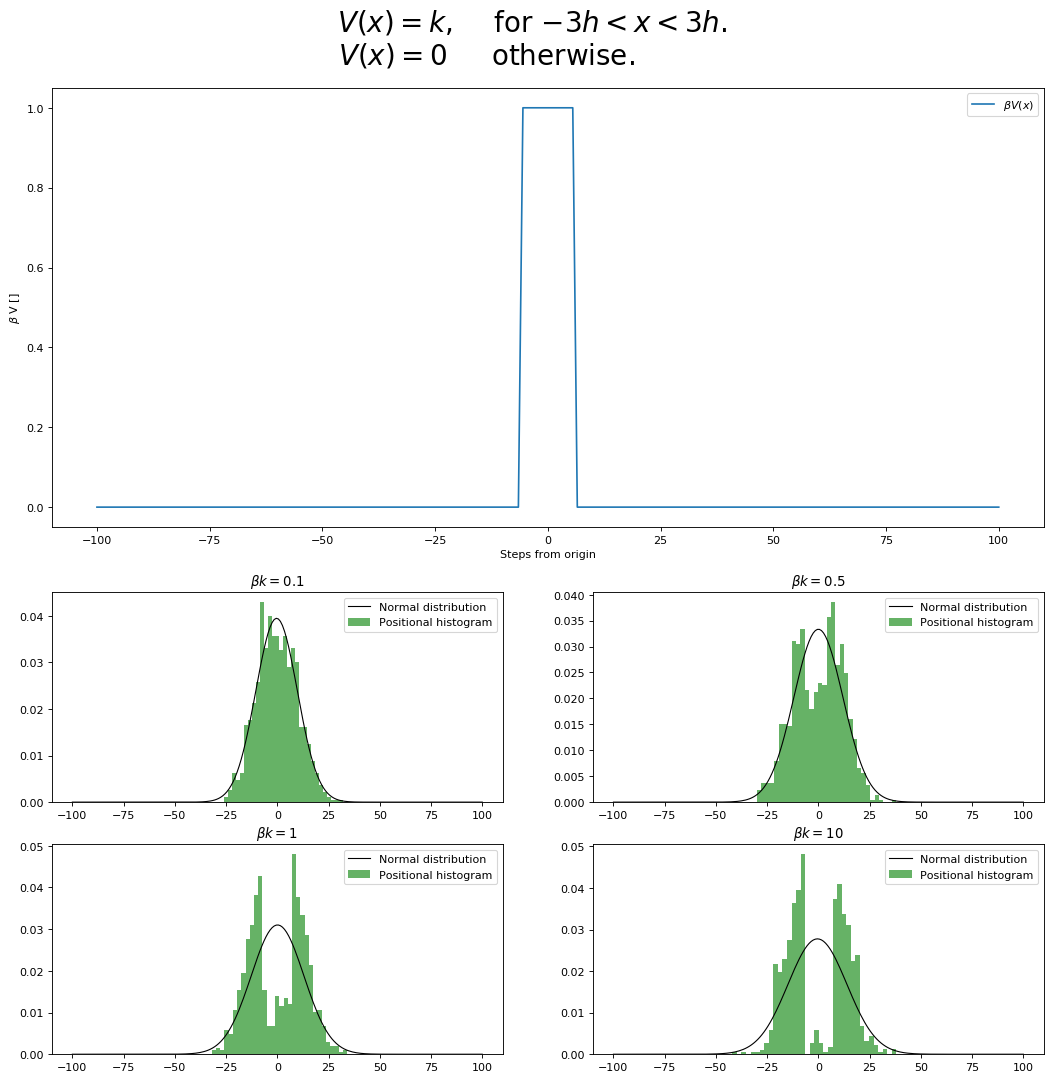

In [4]:
betaKValues2 = (0.1, 0.5, 1, 10)
titleMain = "$V(x)=k,$    for $−3h<x<3h.$\n$ V(x)=0$     otherwise.           "
lstParticles2, titleSub = getDataFourPlots(V2, betaKValues2, 0.1)
plotNormFour(lstParticles2, titleMain, titleSub, titleNewLines = 1, V=V2)

As the plot of the potential shows, the potential is constant for a given interval of $x$ centered around $x = 0$, and zero for the remainder of the interval. Both within and outside of the potential are complete random walks in which there is an equal probability of moving to the left and right. However when the particle is at the threshold of the potential drop, it is more likely to move away from the potential. When the particle has dropped, the likelihood of it entering the potential again is small and decreasing with increasing $\beta k$. This results in plots in which the particles are more likely to stay outside of the center. From the plots one can see that the distribution does not align well with a normal distribution, specially with higher $\beta k$. Consequently there normal distribution were not plotted. 

### 5.3)

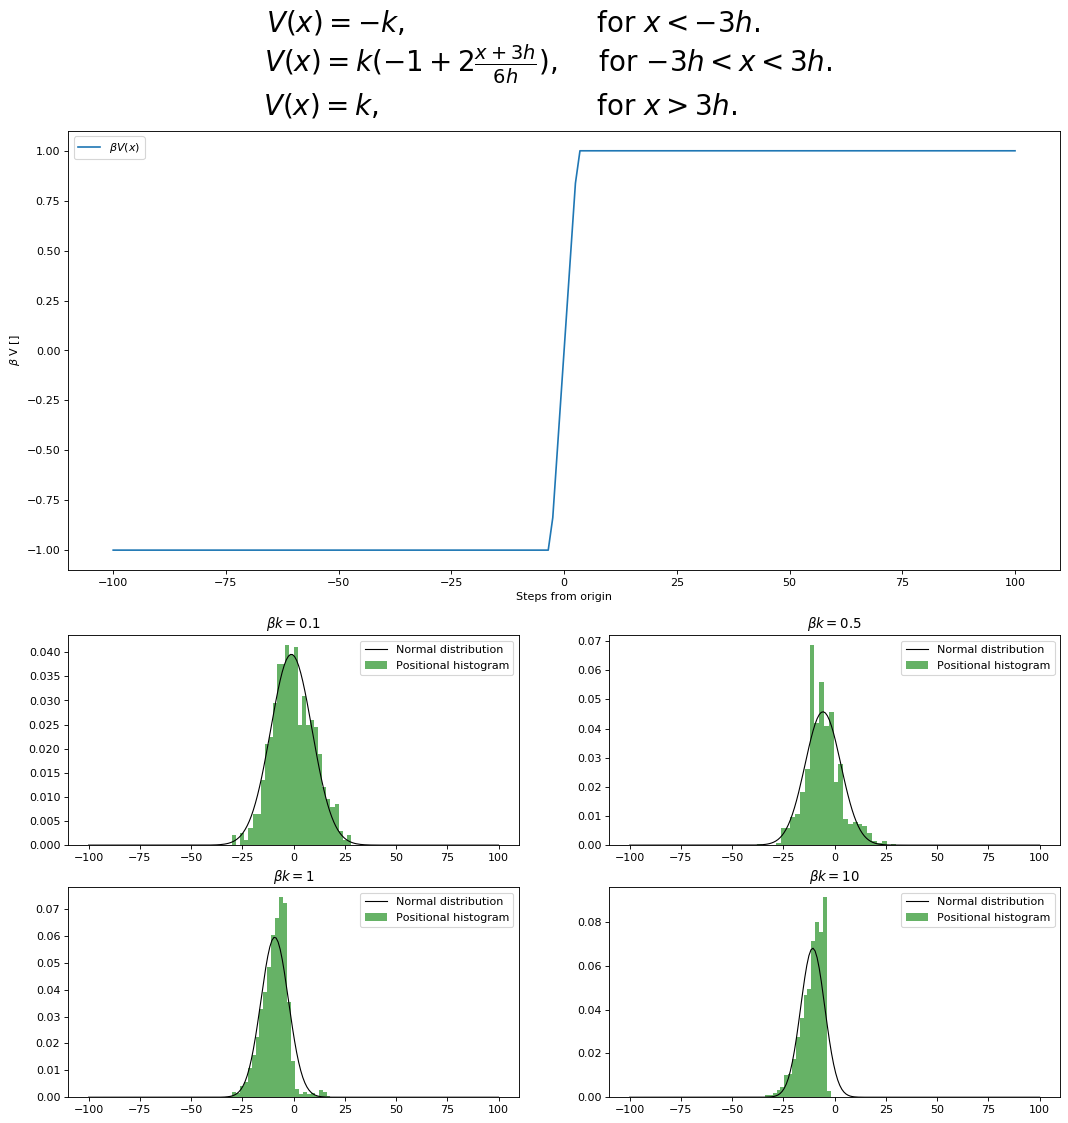

In [5]:
betaKValues3 = (0.1,0.5,1,10)
titleMain = "$V (x) = −k,$\t\t\t  for $x < −3h.$\t\n$ V (x) = k(−1 + 2 \\frac{x + 3h}{6h}),$    for $−3h < x < 3h.$\n$ V (x) = k,$\t\t\t     for $x > 3h.$\t     "
lstParticles3, titleSub = getDataFourPlots(V3, betaKValues3, 0.001)
plotNormFour(lstParticles3, titleMain, titleSub, titleNewLines = 2, V=V3)

As the potential-plot shows, this potential is a continous function in which there are two areas where the potential is constant and an area between where the potential is linearly increasing as x increases. The arguments as to where the particles move are similar to the aforementioned potentials, and as expected the random walks favor a walk towards left as $\beta k$ increases. It is also woth noting that with an increase in $\beta k$ the particle distribution doesn't align well with a normal distribution since they are affected by an outside potential. However when the potential is relatively small the result is more of a random walk which from task three we know follows a normal distribution. 

## Oppgave 7

In [6]:
V_values1, sodium1, potassium1 = randWalkCell(0,0)
V_values2, sodium2, potassium2 = randWalkCell(1,1)
V_values3, sodium3, potassium3 = randWalkCell(3,3)
t = np.linspace(0, len(V_values1) - 1, len(V_values1))

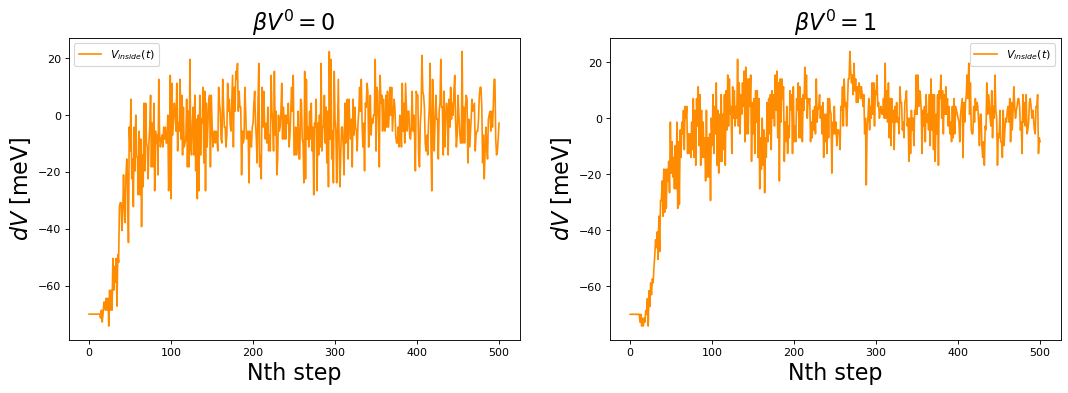

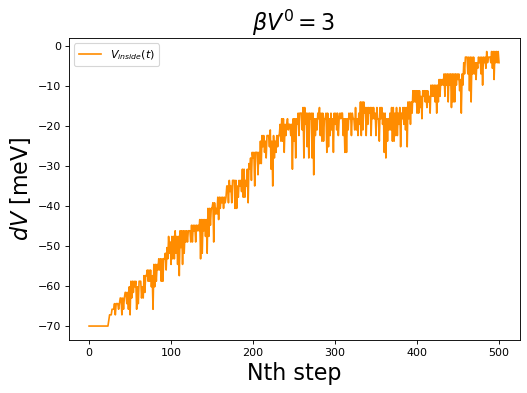

In [7]:
xlabel = "Nth step"
ylabel = "$dV$ [meV]"

plot_sbs(t, t, [[V_values1, "darkorange", "$V_{inside}(t)$"]], [[V_values2, "darkorange", "$V_{inside}(t)$"]],
         xl1=xlabel, xl2=xlabel, yl1=ylabel, yl2=ylabel, t1="$\\beta V^{0} = 0$", t2="$\\beta V^{0} = 1$")

plot_sbs(t, [], [[V_values3, "darkorange", "$V_{inside}(t)$"]], [],
         xl1=xlabel, yl1=ylabel, t1="$\\beta V^{0} = 3$")

Explanation of the simulation:
In this simulation both types of particles are considered the same type. This means that the at the start of the simulation the system has 1450 particles inside the cell while there are 1500 particles outside. All these particles are exposed to random walks, and are supposed to help simulate the concentration gradient in order to simulate diffusion. In a natural cell however, the number of particles outside the cell is several magnitutes higher than that inside the cell. In order to simulate this, the outside concentration is set constant, equal to 150 mM. This concentration is used to calculate the electric potential of the system. This is a simplification, because even though the outside potential stays constant, the number of particles outside changes. $\beta V_0$ is an parameter for the strength of the potential barrier. 

There are two forces that drives the particles: diffusion and electric drift. Let's start with diffusion. Diffusion is the process where particles naturally move towards an area of lower concentration. This negative gradient is calculated by using the particles that are run in the simulation. Until the number of particles on both sides of the cell wall are equal, diffusion drives particles towards the inner part of the cell as there are 50 fewer particles here. If diffusion was the only process happening in the cell, the diffusion would effectively stop after a net transfer of 25 particles. Due to the small difference of particles between inside and outside, diffusion is almost negligible throughout this simulation since the difference in the number of particles on each side is at most $5 \%$.

The electric potential effectively transfers more particles towards the inside of the cell because the charge gradient remains negative in the inwards direction. This is because the outside concentration remains 150 mM whilst the inside concentration gradually increases as the inside concentration is proportional to the number of particles inside (note that this is not the case with the outside concentration). As a result, the potential will continously push particles inwards until 50 particles are transferred. The gradient gradually weakens as the ion concentration difference decreases.

Taking these two driving forces into account it is possible to describe the drift of the particles. From the beginning until a net transfer of 25 particles, both of these forces will work to push the particles inwards. However since the mass concentration gradient (calculated from the random walking particles) is negligible, the force that drives the particles is in a practicle sense only the electric drift. However, as the net transferred particles inside increases beyond 25, the number of particles inside is higher than outside, which means that the particle concentration gradient changes direction and gradually increases while the electric drift decreases as the concentration of ions inside increases. At some point these forces reach eqilibrium. It is reached when $V = 0$ because this is where the electric drift stops, meaning that since diffusion throughout this simulation is negligible, electric drift is run until the charge gradient effectively is zero.

As expected the graphs converge to $\Delta V = 0$. An increase in $\beta V_0$ increases the potential barrier. This results in a slower diffusion as the particles will  more likely be repelled by the membrane. This explains why the third graph increases slower than the first. 

### 7b)

In [8]:
V_values4, sodium4, potassium4 = randWalkCell(10,1, iter=1000)
t2 = np.linspace(0, 1000, 1001)
V_values5, sodium5, potassium5 = randWalkCell(1,10)

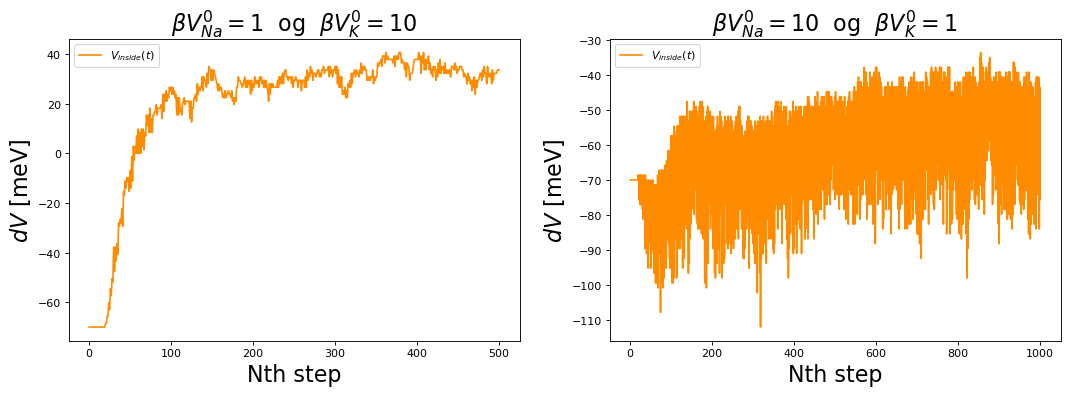

In [9]:
plot_sbs(t, t2, [[V_values5,"darkorange", "$V_{inside}(t)$"]], [[V_values4,"darkorange", "$V_{inside}(t)$"]],
         xl1=xlabel, xl2=xlabel, yl1=ylabel, yl2=ylabel,
         t2="$\\beta V^{0}_{Na} = 10$  og  $ \\beta V^{0}_{K} = 1$",
         t1="$\\beta V^{0}_{Na} = 1$  og  $\\beta V^{0}_{K} = 10$")

The setup of the simulations are the same in both cases; with 50 sodium and 1400 potassium particles inside and 1450 sodium and 50 potassium particles outside. The left simulation simulates diffusion in which the potassium gate is virtually closed while the sodium gate is open. The right simulation simulates the opposite.

In the left simulation the sodium particles are practically the only type of particles able to cross the membrane. In contrast to the last set of simulations, there is a significantly large difference in concentration of relevant particles inside and outside. This results in a natural diffusion that has to be accounted for. Similar to previous simulations both forces work inwards to begin with. The diffusion will keep working inwards while the electric drift changes direction. Since the driving force from natural diffusion becomes weaker while the potential grows stronger, the system will eventually reach equilibrium. This equilibrium is reached at a nonzero $\Delta V$. In our simulation this was around $\Delta V = 30$. This is shown in the graph to the left as the voltage changes sign. 

The right simulation has a closed sodium gate meaning that the potassium particles can pass through the membrane. Once again the concentration difference is signinficant and is directed out of the cell, while the potential pushes the particles inwards. The charge difference compared to the particle difference results in a net drift inwards until equilibrium is reached. As expected, the sign of the voltage difference $\Delta V$ in this simulation doesn't change. 

## 8.1)

In [10]:
consentrationLst = [];
V_values6, sodium6, potassium6 = randWalkCellWithGates(iter = 1000, consentrationLst=consentrationLst);

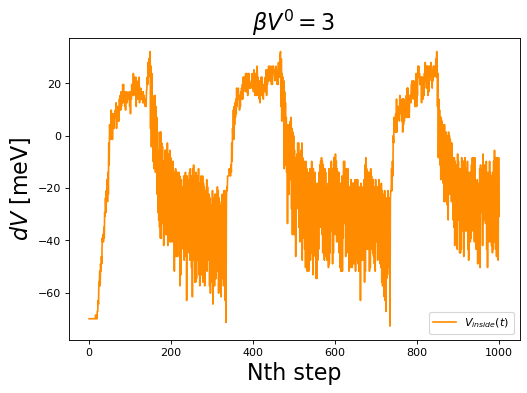

Consentrations of potassium at the lower threshold after 0 cycle(s):
Inside: 0.14       Outside: 0.005      Inside membrane: 0.0 

Consentrations of potassium at the lower threshold after 1 cycle(s):
Inside: 0.1324     Outside: 0.0088     Inside membrane: 0.0038 

Consentrations of potassium at the lower threshold after 2 cycle(s):
Inside: 0.1285     Outside: 0.0122     Inside membrane: 0.0043 



In [11]:
t2 = np.linspace(0, len(V_values6) - 1, len(V_values6))

plot_sbs(t2, [], [[V_values6, "darkorange", "$V_{inside}(t)$"]], [],
         xl1=xlabel, yl1=ylabel, t1="$\\beta V^{0} = 3$")

for i in range(len(consentrationLst)):
    print("Consentrations of potassium at the lower threshold after", i, "cycle(s):")
    print("Inside:", str(round(consentrationLst[i][0], 4)) + " " * (6 - len(str(round(consentrationLst[i][0], 4)))),
          "    Outside:", str(round(consentrationLst[i][1], 4)) + " " * (6 - len(str(round(consentrationLst[i][1], 4)))),
          "    Inside membrane:", abs(round(consentrationLst[i][2], 4)), "\n")

The graph shows the simulation of a cell without the sodium-potassium pump. The sodium gate is open to begin with while the potassium gate is closed. The sodium gate closes when $\Delta V$ reaches $30$meV, while the potassium gate opens. The opposite happens when $\Delta V$ goes down to $-70$meV. 

The cell easily reaches $30$meV when the sodium gate is open, but struggles to reach back down to $-70$meV for the cycle to restart. In addition for each cycle, it becomes rarer to reach the lower threshold. After printing the consentrations after each cycle it becomes clear that the reason for this is that the difference in potassium concentration inside and outside the cell is shrinking. As a consequence, the effect of the diffusion when the potassium gate is open decreases. Even if the simulation were to be run longer, there would still only be a few cycles. 

In [12]:
consentrationLst = []
V_values7, sodium7, potassium7 = randWalkCellWithGates(SPP = True, iter = 5000, consentrationLst=consentrationLst);
t = np.linspace(0, len(V_values7) - 1, len(V_values7))

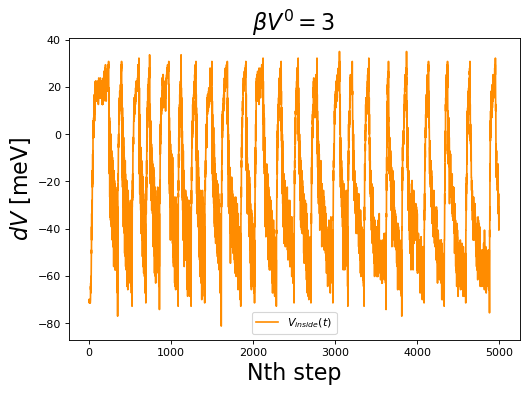

───Potassium consentrations at the lower threshold───

Cycle(s)    Inside       Outside      Inside membrane
0           0.14         0.005        0.0
1           0.1403       0.0007       0.004
2           0.1409       0.0011       0.003
3           0.1398       0.0023       0.0029
4           0.1392       0.0022       0.0036
5           0.1408       0.0007       0.0035
6           0.141        0.001        0.003
7           0.1407       0.0012       0.0031
8           0.1403       0.0009       0.0038
9           0.1419       0.0002       0.0029
10          0.1407       0.0017       0.0026
11          0.1421       0.0005       0.0024
12          0.1422       0.0001       0.0027
13          0.1421       0.0007       0.0022
14          0.1424       0            0.0026
15          0.1401       0.0014       0.0035
16          0.1415       0.0006       0.0029
17          0.1423       0            0.0027
18          0.142        0.0003       0.0027
19          0.1427       0.0001       0.00

In [13]:
plot_sbs(t, [], [[V_values7, "darkorange", "$V_{inside}(t)$"]], [],
         xl1=xlabel, yl1=ylabel, t1="$\\beta V^{0} = 3$")

print("─" * 3 + "Potassium consentrations at the lower threshold" + 3 * "─" + "\n")
print("Cycle(s)    Inside       Outside      Inside membrane")
for i in range(len(consentrationLst)):
    print(i, " " * (10 - len(str(i))), end=" ")
    print(str(round(consentrationLst[i][0], 4)) + " " * (12 - len(str(round(consentrationLst[i][0], 4)))),
          str(round(consentrationLst[i][1], 4)) + " " * (12 - len(str(round(consentrationLst[i][1], 4)))),
          abs(round(consentrationLst[i][2], 4)))

After adding a sodium-potassium pump, the cell no longer has any problem reaching the lower potential threshold. The sodium-potassium pump helps maintain the Na:K ratio inside the cell as well as reducing the inside potential. The table above illustrates how the potassium concentration stays high inside the cell for each time it reaches the lower threshold. Therefore the cycle keeps restarting without trouble.